<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.851 · Tipología y ciclo de vida de los datos</p>
<p style="margin: 0; text-align:right;">Aula 2</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PRA2: ¿Cómo realizar la limpieza y análisis de datos?

Autores: Andrés Merino Toapanta y Mario Cueva Almeida

In [ ]:
# Librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, anderson, levene, pearsonr, ttest_ind, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## 1. Descripción del dataset

El conjunto de datos a analizar se ha recuperado de la plataforma Kaggle ([en este enlace](https://www.kaggle.com/datasets/piterfm/fifa-football-world-cup?resource=download)) y contiene todos los resultados de los partidos de fútbol disputados en las copas mundiales de la FIFA desde 1930 hasta 2022. 

El conjunto de datos contiene 964 partidos (filas) y 44 variables (columnas). Las variables son:
- `home_team`, `away_team`: Equipos local y visitante, respectivamente.
- `home_score`, `away_score`: Marcador final del partido para cada equipo.
- `home_xg`, `away_xg`: Goles esperados para cada equipo.
- `home_penalty`, `away_penalty`: Número de penales a favor de cada equipo, en el desempate.
- `home_manager`, `away_manager`: Nombre de los DT de cada equipo.
- `home_captain`, `away_captain`: Nombre de los capitanes de cada equipo.
- `home_goal`, `away_goal`: Nombre de los anotadores de goles de cada equipo.
- `home_goal_long`, `away_goal_long`: Detalles de los anotadores de goles (minuto, asistente, etc.) de cada equipo.
- `home_own_goal`, `away_own_goal`: Nombre de los anotadores de auto-goles de cada equipo.
- `home_penalty_goal`, `away_penalty_goal`: Nombre de los anotadores de goles con penal de cada equipo.
- `home_penalty_miss_long`, `away_penalty_miss_long`: Detalles de penales que fallaron (nombre de quién cobró, minuto, razón, etc.) de cada equipo.
- `home_penalty_shootout_miss_long`, `away_penalty_shootout_miss_long`: Detalles de penales, en el desempate, que fallaron (nombre de quién cobró, marcador, razón, etc.).
- `home_penalty_shootout_goal_long`, `away_penalty_shootout_goal_long`: Detalles de penales, en el desempate, que acertaron (nombre de quién cobró, marcador, etc.).
- `home_red_card`, `away_red_card`: Detalles de tarjetas rojas dadas directamente a cada equipo.
- `home_yellow_red_card`, `away_yellow_red_card`: Detalles de tarjetas rojas dadas por acumulación de tarjetas amarillas a cada equipo.
- `home_yellow_card_long`, `away_yellow_card_long`: Detalles de tarjetas amarillas dadas a cada equipo.
- `home_substitute_in_long`, `away_substitute_in_long`: Detalles de las sustituciones realizadas por cada equipo.
- `Attendance`: Asistencia al estadio.
- `Venue`: Estadio donde se jugó el partido.
- `Officials`: Árbitros del partido.
- `Round`: Ronda en la que se jugó el partido.
- `Date`: Fecha del partido.
- `Score`: Marcador final del partido.
- `Referee`: Árbitro principal.
- `Notes`: Notas adicionales del partido.
- `Host`: País anfitrión.
- `Year`: Año en el que se jugó el partido.

Con este conjunto de datos se pueden abordar diferentes problemáticas como las siguientes:
- ¿La métrica de goles esperados (xG) es una buena métrica para evaluar el rendimiento de un equipo?
- ¿Cuáles son la variables más correlacionadas con el resultado del partido?
- ¿El número de tarjetas amarillas o rojas es mayor en los partidos de la fase eliminatoria que en la de los grupos?
- ¿Se puede predecir el resultado del desempate con los datos del partido?

Las respuestas a estas preguntas pueden, por un lado, orientar a los directores técnicos de cada equipo para plantear estrategias que les favorezca, dependiendo del escenario en el que se encuentre; por otro lado, podría ser utilizado por las personas que realizan apuestas, o casas de apuestas, para mejorar sus decisiones.

## 2. Integración y selección de los datos de interés a analizar. 

Puede ser el resultado de adicionar diferentes datasets o una subselección útil de los datos originales, en base al objetivo que se quiera conseguir.

Dado que en el análisis no es relevante datos como los nombres de directores o jugadores, tomaremos únicamente las siguientes variables de las cuales podremos obtener la información necesaria:

- `home_score` 
- `home_xg`  
- `home_penalty` 
- `away_score` 
- `away_xg`
- `away_penalty`
- `Round`
- `home_penalty_goal`
- `away_penalty_goal`
-  `home_penalty_miss_long` 
-  `away_penalty_miss_long` 
-  `home_red_card` 
-  `away_red_card` 
-  `home_yellow_card_long` 
-  `away_yellow_card_long` 
-  `home_substitute_in_long` 
-  `away_substitute_in_long`

Además, varias de estas variables tienen un nivel de detalle que no se involucrará en el análisis, por ejemplo, el `home_penalty_goal` posee la información de quién anotó el penal y el minuto; de esto solo nos interesa cuántos penales se anotaron, por lo cual, dividimos la lista por el separador y contamos la cantidad de datos. Esto lo guardamos con el mismo nombre de columna.

Por otro lado, la variable `Round` la refactorizamos para unicamente contar con la información de si es un partido de la etapa de grupos o de la eliminatoria.

Finalmente, generamos una variable que nos indique cuál fue el resultado, en la cual colocamos 1 si el equipo local ganó, -1 si perdió y 0 si empató.

In [ ]:
# Carga de los datos
df = pd.read_csv('data/matches_1930_2022.csv')

# Selección de las columnas que contarán en el análisis
columnas = [ 'Round',
       'home_score', 'home_xg', 'home_penalty',
       'away_score', 'away_xg', 'away_penalty',
       'home_penalty_goal', 'away_penalty_goal', 
       'home_penalty_miss_long', 'away_penalty_miss_long',
       'home_red_card', 'away_red_card',
       'home_yellow_card_long', 'away_yellow_card_long', 
       'home_substitute_in_long', 'away_substitute_in_long']
df = df[columnas]


# Crear una lista con los nombres de las columnas en las que se debe contar los elementos
columnas = ['home_penalty_goal', 'away_penalty_goal',
           'home_red_card', 'away_red_card']

# Contar la cantidad de elementos de las columnas
for columna in columnas:
    df[columna] = df[columna].str.split('|').str.len()


# Crear una lista con los nombres de las columnas en las que se debe contar los elementos
columnas = ['home_penalty_miss_long', 'away_penalty_miss_long',
           'home_yellow_card_long', 'away_yellow_card_long',
           'home_substitute_in_long', 'away_substitute_in_long']

# Contar la cantidad de elementos de las columnas
for columna in columnas:
    df[columna] = df[columna].str.split(',').str.len()

# Variable round 0 en fase de grupos y 1 clasificatoria
df['round'] = np.where(df['Round'] == "Group stage", 0, 1)
df = df.drop(['Round'], axis=1)

# Variable resultado: 1 si ganó home -1 si ganó away, 0 si empataron.
df['result'] = np.where(df['home_penalty'] > df['away_penalty'], 1, 0)
df['result'] = np.where(df['home_penalty'] < df['away_penalty'], -1, df['result'])
df['result'] = np.where(df['home_score'] > df['away_score'], 1,  df['result'])
df['result'] = np.where(df['home_score'] < df['away_score'], -1,  df['result'])

# Visualización de los datos
df.head()

,home_score,home_xg,home_penalty,away_score,away_xg,away_penalty,home_penalty_goal,away_penalty_goal,home_penalty_miss_long,away_penalty_miss_long,home_red_card,away_red_card,home_yellow_card_long,away_yellow_card_long,home_substitute_in_long,away_substitute_in_long,round,result
0,3,3.3,4.0,3,2.2,2.0,1.0,2.0,NaN,NaN,NaN,NaN,5.0,3.0,6.0,7.0,1,1
1,2,0.7,NaN,1,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,5.0,1,1
2,2,2.0,NaN,0,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,5.0,1,1
3,3,2.3,NaN,0,0.5,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,2.0,5.0,5.0,1,1
4,1,1.4,NaN,0,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,5.0,5.0,1,1


## 3. Limpieza de los datos

### 3.1 Gestión de ceros o elementos vacíos

Revisamos la información de los datos:

In [ ]:
# Revisión de la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   home_score               964 non-null    int64  
 1   home_xg                  128 non-null    float64
 2   home_penalty             35 non-null     float64
 3   away_score               964 non-null    int64  
 4   away_xg                  128 non-null    float64
 5   away_penalty             35 non-null     float64
 6   home_penalty_goal        116 non-null    float64
 7   away_penalty_goal        84 non-null     float64
 8   home_penalty_miss_long   6 non-null      float64
 9   away_penalty_miss_long   9 non-null      float64
 10  home_red_card            51 non-null     float64
 11  away_red_card            54 non-null     float64
 12  home_yellow_card_long    621 non-null    float64
 13  away_yellow_card_long    627 non-null    float64
 14  home_substitute_in_long  7

Podemos apreciar que la mayoría de variables tienen datos nulos, los cuales corresponden, por ejemplo, en la variable `home_penalty`, a que no se anotaron penales en ese partido. Por esta razón, en todas las variables de este estilo, imputamos el valor nulo por 0. 

In [ ]:
# Crear una lista con los nombres de las columnas en las que se debe contar los elementos
columnas = ['home_penalty', 'away_penalty',
            'home_penalty_goal', 'away_penalty_goal',
            'home_red_card', 'away_red_card', 
            'home_penalty_miss_long', 'away_penalty_miss_long',
            'home_yellow_card_long', 'away_yellow_card_long',
            'home_substitute_in_long', 'away_substitute_in_long']

# Cambio de los valores nulos por 0
for columna in columnas:
    df[columna] = df[columna].fillna(0)

# Revisión de la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   home_score               964 non-null    int64  
 1   home_xg                  128 non-null    float64
 2   home_penalty             964 non-null    float64
 3   away_score               964 non-null    int64  
 4   away_xg                  128 non-null    float64
 5   away_penalty             964 non-null    float64
 6   home_penalty_goal        964 non-null    float64
 7   away_penalty_goal        964 non-null    float64
 8   home_penalty_miss_long   964 non-null    float64
 9   away_penalty_miss_long   964 non-null    float64
 10  home_red_card            964 non-null    float64
 11  away_red_card            964 non-null    float64
 12  home_yellow_card_long    964 non-null    float64
 13  away_yellow_card_long    964 non-null    float64
 14  home_substitute_in_long  9

Podemos apreciar que continuamos con valores nulos en las variables relacionadas con la métrica de goles esperados. Esto se debe a que, antes de 2018, no se contaba con esta medida. Por esta razón, lo dejaremos como valor perdido y tendremos en cuenta cuando se realicen los análisis correspondientes.

### 3.2 Identificar y gestionar los valores extremos

Dado que algunas de las variables tienen valores igual a 0 en la mayoría de registros pues, por ejemplo, en la mayoría de partidos se tiene 0 goles de penal, vamos a dividir el análisis de valores extremos en dos etapas. 

Primero analizaremos los valores extremos de las variables que suelen tomar valores diferentes de 0:

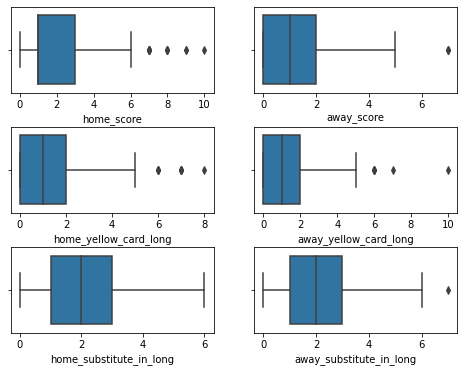

In [ ]:
# Generación de gráficos boxplot de cada variable
columnas = ['home_score', 'away_score',
            'home_yellow_card_long', 'away_yellow_card_long',
            'home_substitute_in_long', 'away_substitute_in_long']

# Subplots
fig, ax = plt.subplots(3, 2, figsize=(8, 6))
plt.subplots_adjust(hspace=0.4)

# Generación de los boxplot
for columna in columnas:
    i = columnas.index(columna) // 2
    j = columnas.index(columna) % 2
    sns.boxplot(x=df[columna], ax=ax[i,j])

A pesar de que todos los valores extremos son válidos, pueden ocasionar problemas al momento de realizar un análisis de relación o de predicción. Procedemos a contabilizar la cantidad de estos valores:

In [ ]:
# Cálculo de cantidad de valores extremos
columnas = ['home_score', 'away_score',
            'home_yellow_card_long', 'away_yellow_card_long',
            'home_substitute_in_long', 'away_substitute_in_long']

# Cálculo de cantidad de valores extremos
df['outliers'] = 0	
for columna in columnas:
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    df[columna + '_outliers'] = np.where((df[columna] < (q1 - 1.5 * iqr)) | (df[columna] > (q3 + 1.5 * iqr)), 1, 0)
    print(f"Cantidad de valores extremos en {columna}: {df[columna + '_outliers'].sum()}")
    df['outliers'] = df['outliers'] + df[columna + '_outliers']

# Total de registros con valores extremos
print('Total de registros con valores extremos: {}'.format(df[df['outliers']>0].shape[0]))

Cantidad de valores extremos en home_score: 15
Cantidad de valores extremos en away_score: 3
Cantidad de valores extremos en home_yellow_card_long: 10
Cantidad de valores extremos en away_yellow_card_long: 6
Cantidad de valores extremos en home_substitute_in_long: 0
Cantidad de valores extremos en away_substitute_in_long: 1
Total de registros con valores extremos: 33


Dado que los 33 registros no son significativos comparado al tamaño del conjunto de datos (3.4%), procedemos a eliminarlos.

In [ ]:
# Eliminación de los registros atípicos
df = df[df['outliers']==0]

# Eliminación de las columnas de outliers
df = df.drop([columna + '_outliers' for columna in columnas], axis=1)
df = df.drop(['outliers'], axis=1)

print(f"Total de registros: {df.shape}")

Total de registros: (931, 18)


Ahora, realizamos los gráficos del resto de variables, pero omitimos los datos iguales a 0.

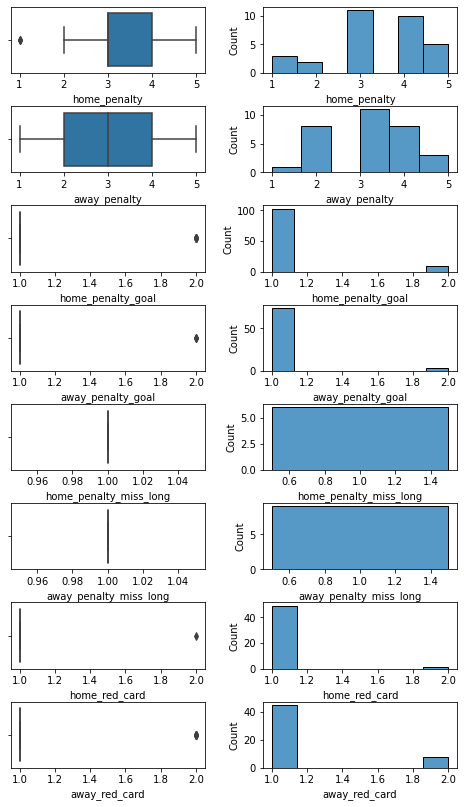

In [ ]:
# Generación de gráficos boxplot de cada variable
columnas = ['home_penalty', 'away_penalty', 'home_penalty_goal', 'away_penalty_goal',
       'home_penalty_miss_long', 'away_penalty_miss_long', 'home_red_card',
       'away_red_card']

# Subplots
fig, ax = plt.subplots(8, 2, figsize=(8, 14))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Generación de los histogramas
for columna in columnas:
    i = columnas.index(columna)
    sns.boxplot(x=df[df[columna]>0][columna], ax=ax[i,0])
    sns.histplot(x=df[df[columna]>0][columna], ax=ax[i,1])

Observamos que, bajo esta consideración, no se tienen valores extremos.

Para finalizar, guardamos los datos en un archivo csv.

In [ ]:
# Guardado del conjunto de datos
df.to_csv('data/matches_1930_2022_clean.csv', index=False)

## 4. Análisis de los datos

### 4.1. Selección de los grupos de datos que se quieren analizar/comparar 

Para la segmentación de los grupos, se usará si el partido pertenece a la fase de grupos o a la de eliminatoria. Estos grupos podrían presentar diferencias dado que los partidos de eliminatoria son más decisivos. Por otro lado, también se dividirá por el resultado del partido, para ver si hay diferencias entre los partidos ganados, perdidos o empatados.

In [ ]:
# Agrupación por etapa
df_groups = df[df['round']==0].copy()
df_playoff = df[df['round']==1].copy()

# Agrupación por resultado
df_win = df[df['result']==1].copy()
df_draw = df[df['result']==0].copy()
df_lose = df[df['result']==-1].copy()

### 4.2. Comprobación de la normalidad y homogeneidad de la varianza

Analizaremos la normalidad de los datos utilizando el test de Kolmogorov-Smirnov ya que tenemos una cantidad considerable de datos  y hemos eliminado los datos extremos. Analizando si el $p$ valor es mayor a 0.05, podemos concluir que es probable que la variable tenga una distribución normal.

In [ ]:
for columna in df:
    _, p = normaltest(df[columna])
    if p > 0.05:
        print(f"La columna {columna} probablemente sigue una distribución normal.")

La columna away_substitute_in_long posiblemente sigue una distribución normal.


Con esto, tenemos que solo una variable, `away_substitute_in_long`, probablememnte posee una distribución normal.

Ahora, para analizar la homogeneidad de la varianza, utilizaremos el test de Levene. Iniciaremos comparando los datos entre los partidos de grupos y de eliminatoria.

In [ ]:
for columna in df:
    _, p = levene(df_groups[columna], df_playoff[columna])
    if p <= 0.05:
        print(f"La varianza de la columna {columna} en ambos dataframes es diferente.")

La varianza de la columna home_score en ambos dataframes es diferente.
La varianza de la columna home_penalty en ambos dataframes es diferente.
La varianza de la columna away_score en ambos dataframes es diferente.
La varianza de la columna away_penalty en ambos dataframes es diferente.
La varianza de la columna away_red_card en ambos dataframes es diferente.
La varianza de la columna away_substitute_in_long en ambos dataframes es diferente.
La varianza de la columna result en ambos dataframes es diferente.


Tenemos que 7 variables no tienen homogeneidad en la varianza.

Ahora, realizamos lo mismo entre los grupos de partidos ganados, perdidos y empatados.

In [ ]:
for columna in df:
    _, p = levene(df_win[columna],df_draw[columna] , df_lose[columna])
    if p <= 0.05:
        print(f"La varianza de la columna {columna} en ambos dataframes es diferente.")

La varianza de la columna home_score en ambos dataframes es diferente.
La varianza de la columna home_penalty en ambos dataframes es diferente.
La varianza de la columna away_score en ambos dataframes es diferente.
La varianza de la columna away_penalty en ambos dataframes es diferente.
La varianza de la columna home_penalty_goal en ambos dataframes es diferente.
La varianza de la columna away_penalty_goal en ambos dataframes es diferente.
La varianza de la columna home_red_card en ambos dataframes es diferente.
La varianza de la columna away_red_card en ambos dataframes es diferente.
La varianza de la columna home_substitute_in_long en ambos dataframes es diferente.
La varianza de la columna away_substitute_in_long en ambos dataframes es diferente.
La varianza de la columna round en ambos dataframes es diferente.


Como era de esperarse, tenemos más variables que presentan diferencias en la varianza.

### 4.3. Aplicación de pruebas estadísticas para comparar los grupos de datos.

En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.

Iniciamos analizando la correlación entre la cantidad de goles anotados y la cantidad de goles esperados.

In [ ]:
# Extracción de las columnas 
col_1_home = df[df["home_xg"].notnull()]["home_xg"]
col_2_home = df[df["home_xg"].notnull()]["home_score"]
col_1_away = df[df["away_xg"].notnull()]["away_xg"]
col_2_away = df[df["away_xg"].notnull()]["away_score"]
# Concatenación de las columnas
col_1 = pd.concat([col_1_home, col_1_away])
col_2 = pd.concat([col_2_home, col_2_away])
# Cálculo de la correlación
corr, p_value = pearsonr(col_1, col_2)
# Impresión de los resultados
print("La correlación entre col_1 y col_2 es: ", corr)
print("p-valor :",p_value)

La correlación entre col_1 y col_2 es:  0.5474207148146943
p-valor : 3.6459353590661565e-20


Vemos que el nivel de correlación no es alto.

Ahora, analicemos la correlación entre las variables y el resultado del partido.

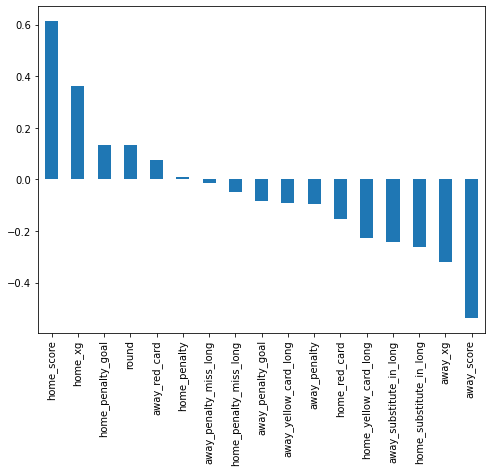

In [ ]:
# Cálculo de las correlaciones
corr = df.drop(["result"], axis=1).apply(lambda col: col.corr(df["result"]))
corr = corr.sort_values(ascending=False)
# Generación del gráfico
fig, ax = plt.subplots(figsize=(8, 6))
corr.plot(kind='bar')
plt.show()

Tenemos que las variables más correlacionadas son la cantidad de goles y los goles esperados, en ambos equipos.

A continuación, analicemos si en un partido de la ronda eliminatoria se tienen más tarjetas que en los partidos de la fase de grupos.

Para esto, la hipótesis nula sería que la media de tarjetas en los partidos en la fase eliminatoria es menor o igual a la media en la fase de grupos. La hipótesis alternativa sería que la media de tarjetas en la fase eliminatoria es mayor a la media en la fase de grupos.

Dado que no tenemos normalidad en las variables, utilizamos la prueba no paramétrica de Mann-Whitney U.

In [ ]:
tarjetas_playoff = df_playoff['home_yellow_card_long'] + df_playoff['away_yellow_card_long'] + df_playoff["home_red_card"] + df_playoff["away_red_card"]
tarjetas_groups = df_groups['home_yellow_card_long'] + df_groups['away_yellow_card_long'] + df_groups["home_red_card"] + df_groups["away_red_card"]

_, p = mannwhitneyu(tarjetas_playoff, tarjetas_groups)
print(f"p-valor:{p}")
if p/2 < 0.05:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-valor:0.03543211223321652
Rechazamos la hipótesis nula


Al rechazar la hipótesis nula, tenemos que hay evidencia estadística para decir que en los partidos de fase eliminatoria se tienen más tarjetas que en los partidos de la fase de grupos.

Finalmente, para revisar si es posible predecir los resultados del partido en función de los datos del mismo (omitiendo los datos relacionados a la cantidad de goles), planteamos un modelo de Árbol de decisión y lo entrenamos con el 80% de los datos para probarlo en el 20%.

In [ ]:
# División en datos de entrenamiento y de prueba
X = df.drop(['result'], axis=1)
X = X.drop(["home_xg","away_xg","home_penalty", "away_penalty", "home_score", "away_score"], axis=1)
y = df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Creación del modelo
clf = DecisionTreeClassifier()

# Entrenamiento del modelo
clf.fit(X_train, y_train)

DecisionTreeClassifier()

Generamos las predicciones y presentamos su exactitud y la matriz de confusión:

Exactitud: 0.50


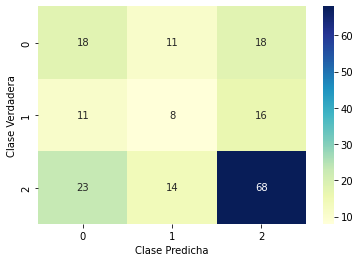

In [ ]:
# Generación de predicciones
y_pred = clf.predict(X_test)

# Evaluación del modelo
acc = accuracy_score(y_test, y_pred)
print("Exactitud: {:.2f}".format(acc))

# Matriz de confunsión
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

Podemos ver que se alcanza una exactitud del 50%, es decir, el modelo no es mejor que un modelo aleatorio.

## 6. Resolución del problema. 

A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?


1.   Uno de los elementos más controversiales presentados en los mundiales de fútbol, es saber con anticipación ¿quién va a ganar en cada partido?, ¿quién será el campeón?, entre otras inquietudes. Para resolver estas inquietudes, ha sido habitual recurrir a los datos estadísticos y su análisis, sin embargo, no ha habido un método adecuado que resuelva esta controversia.
1. Con el avance de la tecnología, se ha desarrollado la Ciencia de Datos, la misma que cuenta con varios algoritmos de Inteligencia Artificial, que luego de un buen entrenamiento con una cantidad considerable de datos, ayudan a predecir ciertos eventos. En este sentido, el fútbol no ha sido la excepción y tomando en cuenta que ya existen experiencias exitosas, decidimos entrenar un árbol de regresión para determinar si es posible predecir el resultado del desempate con los datos generados en el partido. En el presente trabajo, hemos visto que esto no es posible, ya que la exactitud es apenas del 0.5, lo que equivale a usar el azhar. Esto quizá se deba a que los datos con los que se cuenta, no son sufientes. Quizá sea necersario medir el nivel de agotamiento físico y psicológico de los jugadores, entre otras variables posibles para mejorar el entrenamiento del modelo.

1. A pesar de tener 964 registros, aparentemente un buen número para entrenar un algoritmo y obtener buenos resultados, parece ser que no es suficiente, como resultó en el caso de entrenar un árbol de decisión con las datos de un solo partido. Esto posiblemente se dé porque los mundiales de fútbol se realizan cada cuatro años, tiempo en el cual, muchas de las condiciones de cada uno de los equipos cambian, más aún de partido a partido; por ejemplo: el entrenado ya no es el mismo, algunos jugadores ya envejecieron, otros cambiaron de nacionalidad, hay jugadores que ya no pueden jugar ya sea por lesiones o por acumulación de tarjetas. Es así que en el último mundial, 2022, casi todas las selecciones acudieron con al menos un jugador nacionalizado.

2. Con los resultados obtenidos, se ha podido resolver el problema en un cien porciento, aunque esto no signifique que todo es positivo, como la respuesta que se tiene a la pregunta de si se puede predecir el resultado del desempate con solo los datos obtenidos en el partido.





| Contribuciones | Firma |
|----------------|-------|
| Investigación previa | Andrés Merino Toapanta, Mario Cueva Almeida |
| Redacción de las respuestas | Andrés Merino Toapanta, Mario Cueva Almeida |
| Desarrollo del código | Andrés Merino Toapanta, Mario Cueva Almeida |
| Participación en el vídeo | Andrés Merino Toapanta, Mario Cueva Almeida |
